# I. Setup for Data Preprocessing, Training, and Evaluation

## 1. Environment Setup and Data Loading

In [403]:
#Import library
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from io import StringIO
from sklearn.metrics import classification_report, confusion_matrix

penguins = sns.load_dataset("penguins")

## 2. Helper Functions for Model Training and Visualization

In [404]:
#function
def plot_class_distribution(labels, title, ax):
    sns.countplot(x=labels, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    
def trainData(X, Y, size_test):
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y,
        test_size=size_test,
        shuffle=True,
        stratify=Y
    )
    Y_train = Y_train.idxmax(axis=1).apply(lambda x: x.replace('species_', ''))
    Y_test = Y_test.idxmax(axis=1).apply(lambda x: x.replace('species_', ''))

    clf = DecisionTreeClassifier(criterion='entropy')
    clf = clf.fit(X_train, Y_train)
    Y_predict = clf.predict(X_test)
    return X_train, X_test, Y_train, Y_test, clf, Y_predict

def visualizeDataset(Y_original, Y_train, Y_test, size_train, size_test):
    figure, axes = plt.subplots(1, 3, figsize=(18, 5))
    plot_class_distribution(Y_original, "Original Dataset", axes[0])
    plot_class_distribution(Y_train, f"Training Set ({size_train}%)", axes[1])
    plot_class_distribution(Y_test, f"Test Set ({size_test}%)", axes[2])

    print(f"Visualize dataset {size_train}/{size_test}")
    plt.tight_layout()
    plt.show()

def buildTree(clf, X_train, class_names):
    dot_data = StringIO()
    export_graphviz(clf, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True,
                    feature_names=X_train.columns,
                    class_names=class_names['species'])
    return dot_data
    
    
def drawTree(dot_data, size_train, size_test):
    print(f"Decision tree with dataset {size_train}/{size_test}")
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    display(Image(graph.create_png()))  # hiển thị trực tiếp trong notebook    
    
def drawTreeWithDepth(dot_data, depth):
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    print(f"Decision Tree (max_depth={depth})")
    display(Image(graph.create_png()))  # hiển thị đúng trong notebook
    
def classificationReport(Y_test, Y_predict, size_train, size_test):
    print(f"Classification Report ({size_train}/{size_test}):\n")
    print(classification_report(Y_test, Y_predict))
    
def confusionMatrixReport(Y_test, Y_predict, clf, size_train, size_test):
    print(f"Confusion Matrix (Depth={clf.tree_.max_depth}, {size_train}/{size_test} split):\n")
    cm = confusion_matrix(Y_test, Y_predict)
    # Plotting confusion matrix as a heatmap for better visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
def accuraciesReport(accuracies, max_depth):
    results = pd.DataFrame({
        'max_depth': ['None'] + max_depth[1:],
        'Accuracy': accuracies
    })
    results = results.set_index("max_depth").T
    print(results.to_string())
def chartReport(accuracies):
    # Vẽ biểu đồ
    plt.figure(figsize=(8, 6))
    plt.plot(['None', 2, 3, 4, 5, 6, 7], accuracies, marker='o')

    # Hiển thị giá trị độ chính xác tại các điểm
    for i, acc in enumerate(accuracies):
        plt.text(i, acc, f'{acc:.2f}', ha='center', va='bottom')

    plt.title('Decision Tree Accuracy vs Max Depth')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

## 2. Data Preprocessing

In [405]:
#preprocessing data
class_names = {}

for col in penguins.columns:
    if penguins[col].dtype == 'object':
        # Lưu lại tên các nhãn cho từng cột dạng chuỗi
        class_names[col] = penguins[col].unique().tolist()

# One-hot encoding cho tất cả các cột dạng object
penguins_encoded = pd.get_dummies(penguins, dummy_na=True)

feature = [col for col in penguins_encoded.columns if not col.startswith('species_')]
species = [col for col in penguins_encoded.columns if col.startswith('species_')]
X = penguins_encoded[feature]
Y = penguins_encoded[species]
Y_original = Y.idxmax(axis=1).apply(lambda x: x.replace('species_', ''))

# II. Preparing for datasets

## 1. 40/60 Data Split

### 1.1 Train data for 40/60 split

In [406]:
# #Train data 40/60
X_train_40_60, X_test_40_60, Y_train_40_60, Y_test_40_60, clf_40_60, Y_predict_40_60 = trainData(X, Y, 0.6)

### 1.2 Visualizing Class Distribution with 40/60 Data Split

Visualize dataset 40/60


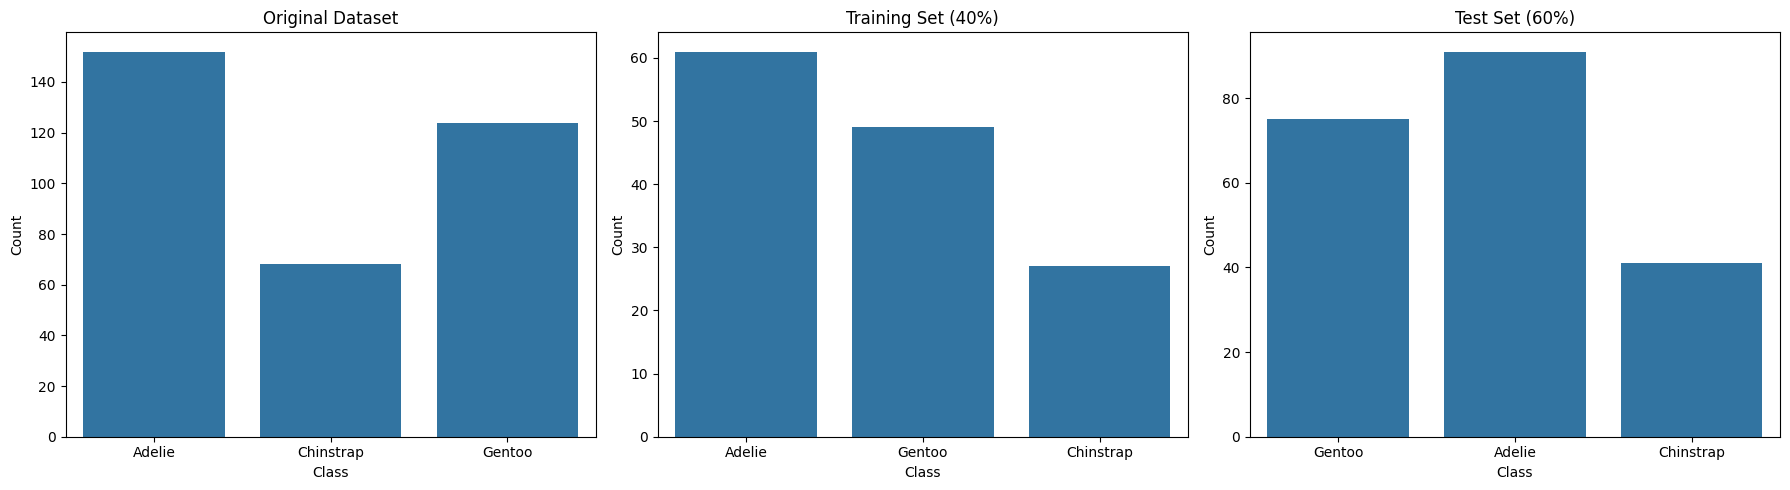

In [407]:
# # Visualize dataset 40/60
visualizeDataset(Y_original, Y_train_40_60, Y_test_40_60, 40, 60)

## 2. 60/40 Data Split

### 2.1 Train data for 60/40 split

In [408]:
# # train data 60/40
X_train_60_40, X_test_60_40, Y_train_60_40, Y_test_60_40, clf_60_40, Y_predict_60_40 = trainData(X, Y, 0.4)

### 2.2 Visualizing Class Distribution with 60/40 Data Split

Visualize dataset 60/40


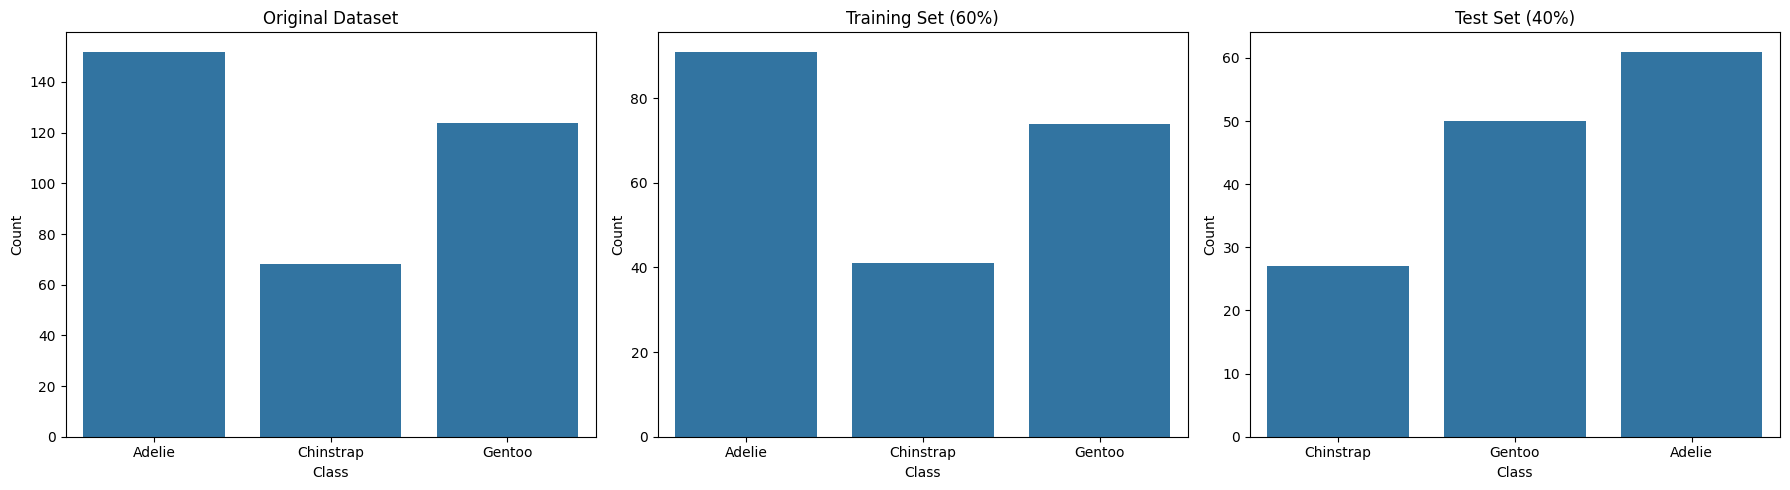

In [409]:
# Visualize dataset 60/40
visualizeDataset(Y_original, Y_train_60_40, Y_test_60_40, 60, 40)

## 3. 80/20 Data Split

### 3.1 Train data for 80/20 split

In [410]:
# Train data 80/20
X_train_80_20, X_test_80_20, Y_train_80_20, Y_test_80_20, clf_80_20, Y_predict_80_20 = trainData(X, Y, 0.2)

### 3.2 Visualizing Class Distribution with 80/20 Data Split

Visualize dataset 80/20


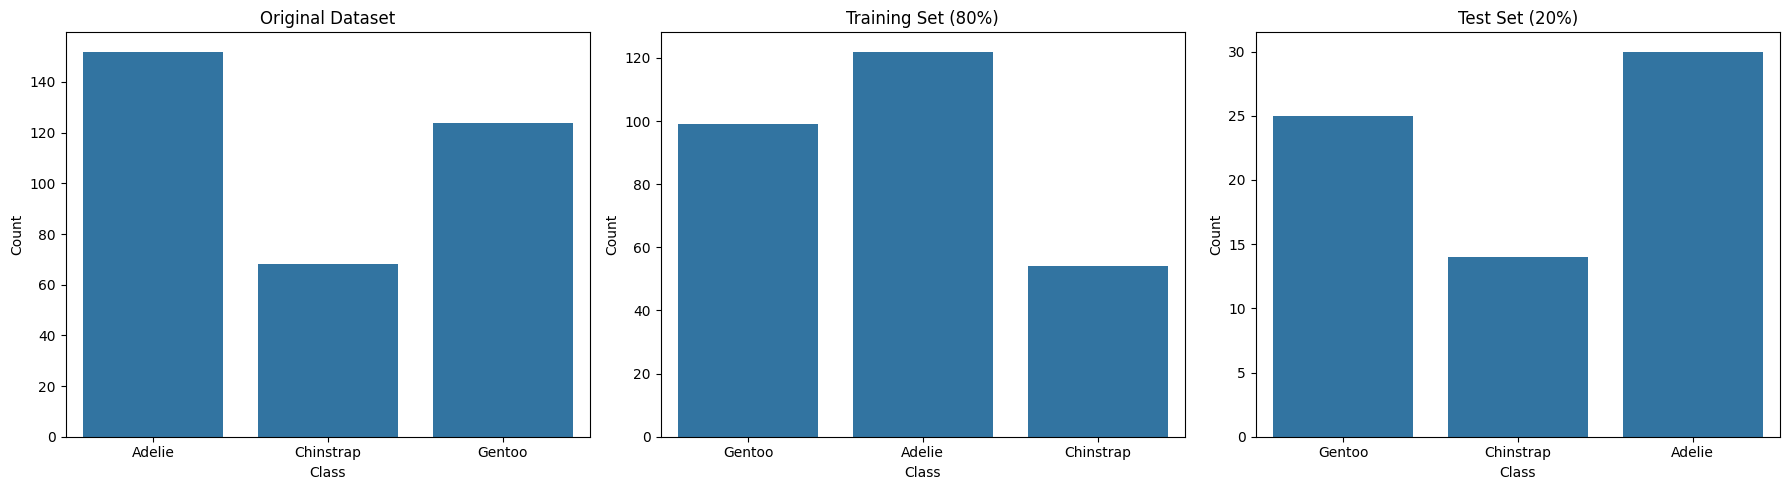

In [411]:
# Visualize dataset 80/20
visualizeDataset(Y_original, Y_train_80_20, Y_test_80_20, 80, 20)


## 4. 90/10 Data Split

### 4.1 Train data for 90/10 split

In [412]:
# Train data 90/10
X_train_90_10, X_test_90_10, Y_train_90_10, Y_test_90_10, clf_90_10, Y_predict_90_10 = trainData(X, Y, 0.1)

### 4.2 Visualizing Class Distribution with 90/10 Data Split

Visualize dataset 90/10


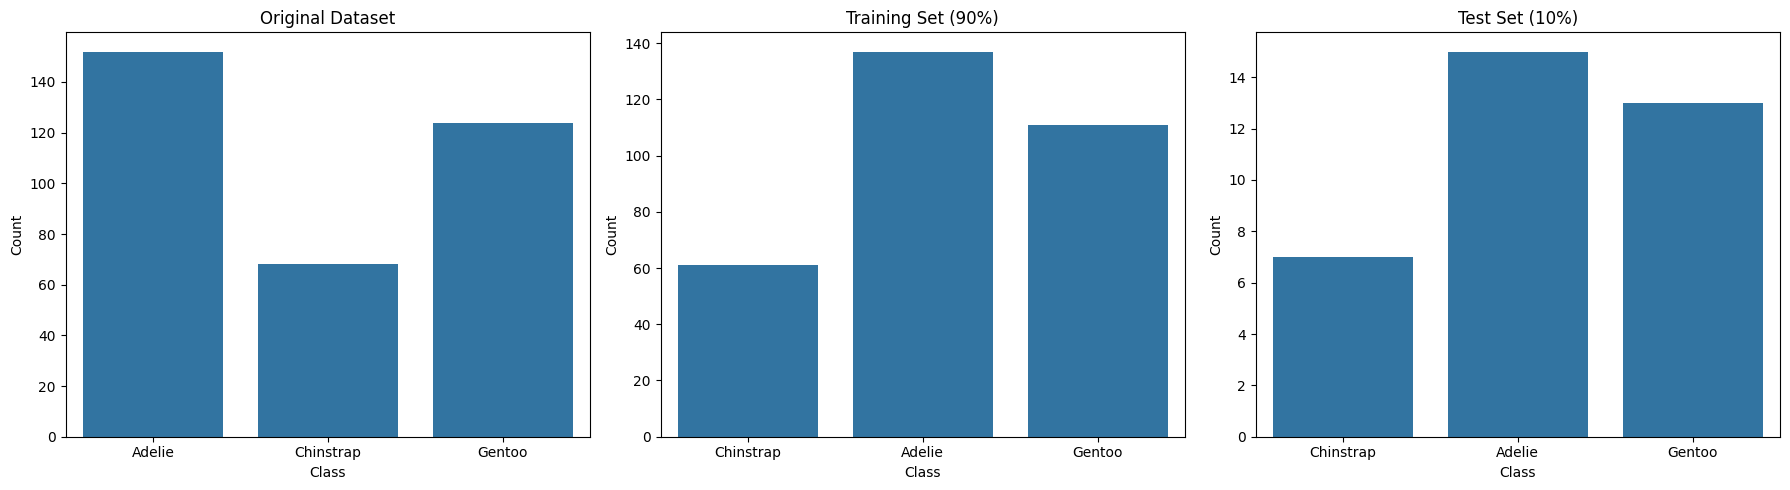

In [413]:
# Visualize dataset 90/10
visualizeDataset(Y_original, Y_train_90_10, Y_test_90_10, 90, 10)


# III. Building the decision tree classifiers

## 1. 40/60 Data Split

### 1.1 Visualizing Decision Tree for 40/60 Data Split

Decision tree with dataset 40/60


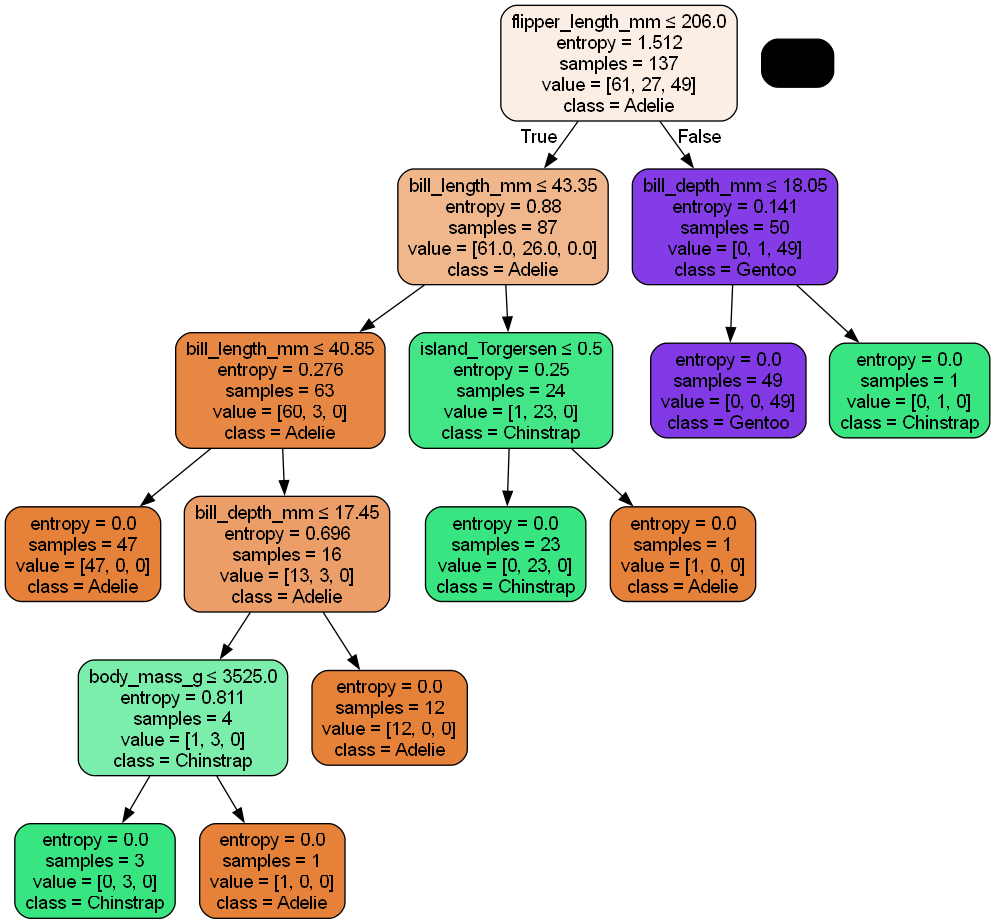

In [414]:
#Decision tree 40/60
dot_data = buildTree(clf_40_60, X_train_40_60, class_names)
drawTree(dot_data, 40, 60)

### 1.2 Classification Report Tree for 40/60 Data Split

In [415]:
classificationReport(Y_test_40_60, Y_predict_40_60, 40, 60)

Classification Report (40/60):

              precision    recall  f1-score   support

      Adelie       0.98      0.96      0.97        91
   Chinstrap       0.91      0.98      0.94        41
      Gentoo       0.99      0.97      0.98        75

    accuracy                           0.97       207
   macro avg       0.96      0.97      0.96       207
weighted avg       0.97      0.97      0.97       207



### 1.3 Confusion Matrix for 40/60 Data Split

Confusion Matrix (Depth=5, 40/60 split):



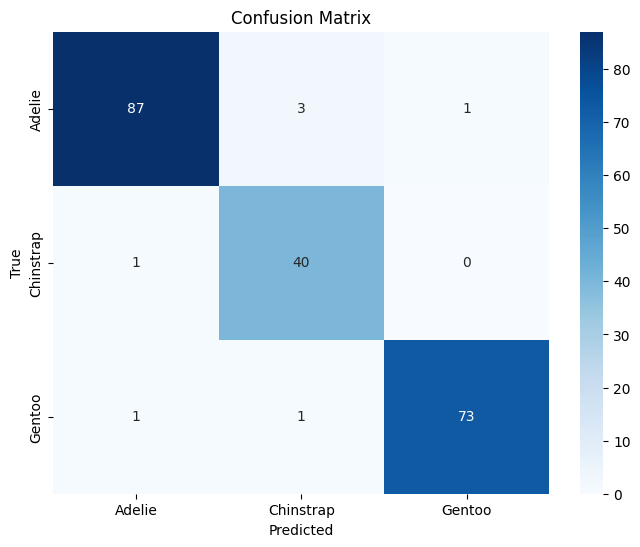

In [416]:
confusionMatrixReport(Y_test_40_60, Y_predict_40_60, clf_40_60, 40, 60)

## 2. 60/40 data split

### 2.1 Visualizing Decision Tree for 60/40 Data Split

Decision tree with dataset 60/40


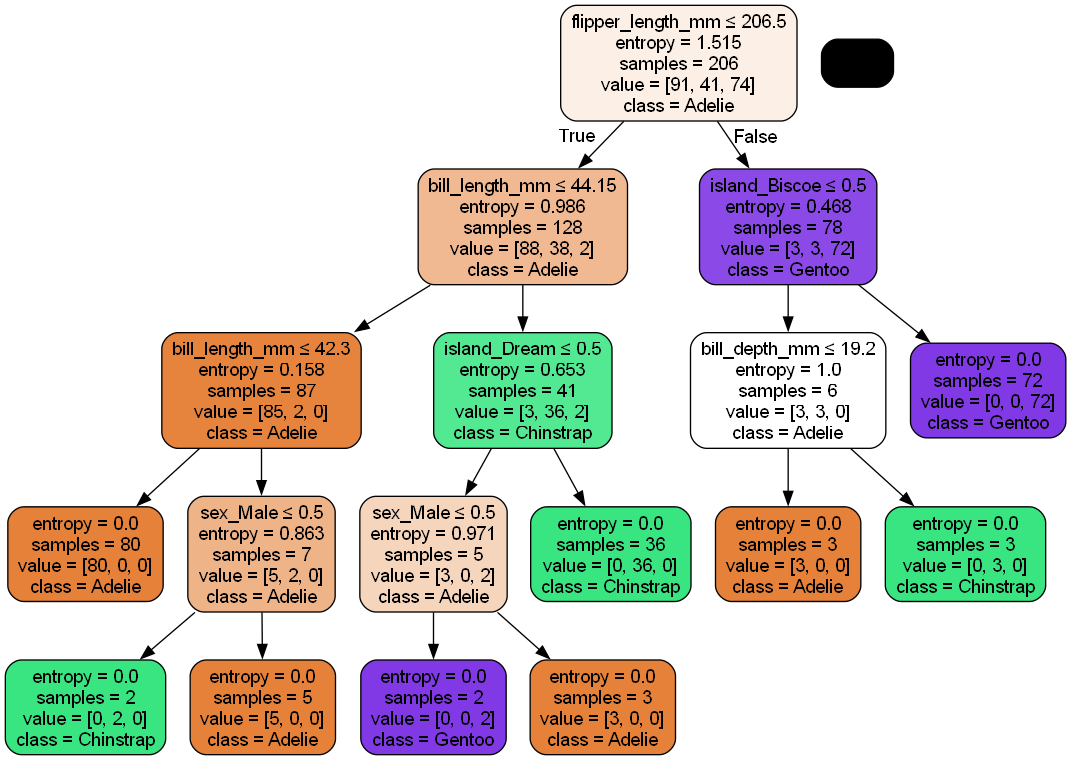

In [417]:
#Decision tree 60/40
dot_data = buildTree(clf_60_40, X_train_60_40, class_names)
drawTree(dot_data, 60, 40)

### 2.2 Classification Report for 60/40 Data Split

In [418]:
classificationReport(Y_test_60_40, Y_predict_60_40, 60, 40)

Classification Report (60/40):

              precision    recall  f1-score   support

      Adelie       0.97      1.00      0.98        61
   Chinstrap       1.00      0.93      0.96        27
      Gentoo       1.00      1.00      1.00        50

    accuracy                           0.99       138
   macro avg       0.99      0.98      0.98       138
weighted avg       0.99      0.99      0.99       138



### 2.3 Confusion Matrix for 60/40 Data Split

Confusion Matrix (Depth=4, 60/40 split):



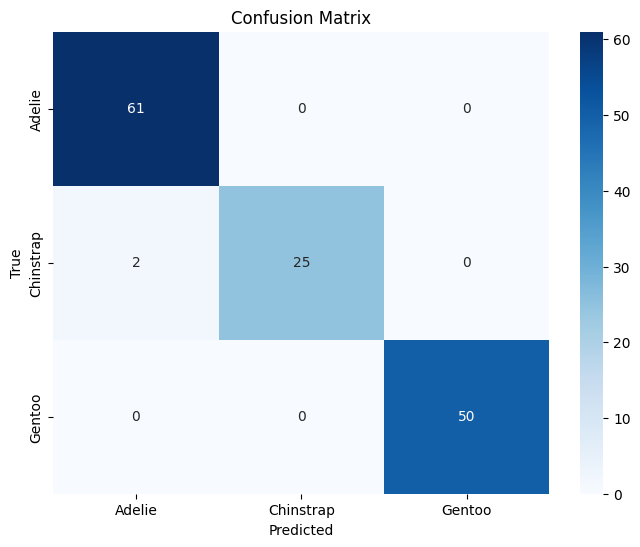

In [419]:
confusionMatrixReport(Y_test_60_40, Y_predict_60_40, clf_60_40, 60, 40)

## 3. 80/20 Data Split

### 3.1 Visualizing Decision Tree for 80/20 Data Split

Decision tree with dataset 80/20


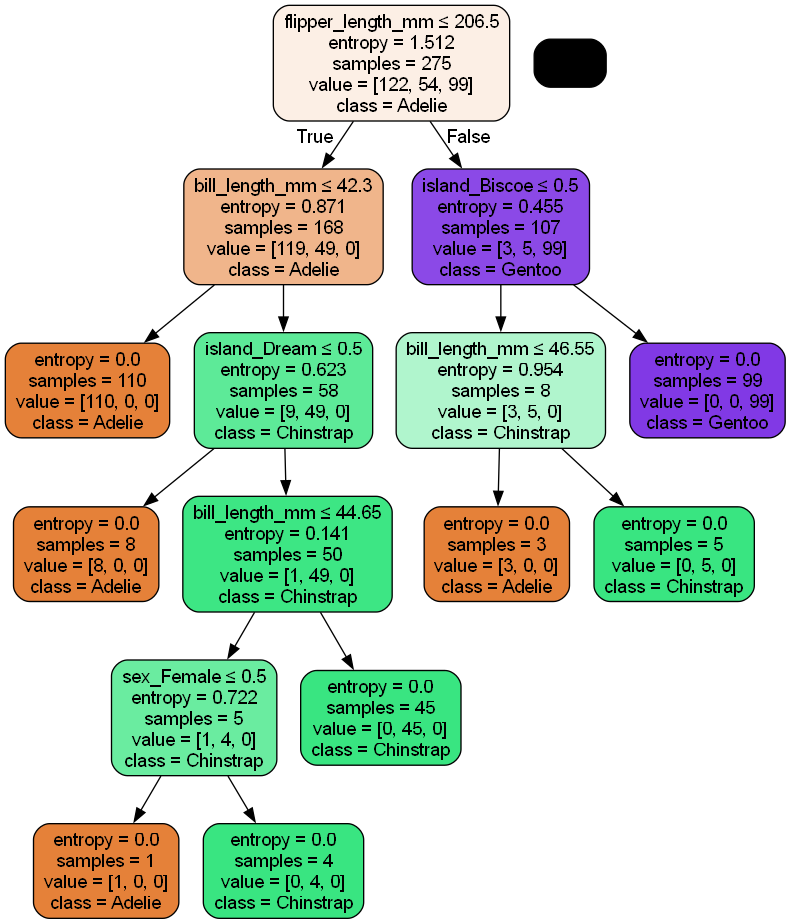

In [420]:
#Decision tree 80/20
dot_data = buildTree(clf_80_20, X_train_80_20, class_names)
drawTree(dot_data, 80, 20)

### 3.2 Classification Report for 80/20 Data Split

In [421]:
classificationReport(Y_test_80_20, Y_predict_80_20, 80, 20)

Classification Report (80/20):

              precision    recall  f1-score   support

      Adelie       0.94      1.00      0.97        30
   Chinstrap       1.00      0.93      0.96        14
      Gentoo       1.00      0.96      0.98        25

    accuracy                           0.97        69
   macro avg       0.98      0.96      0.97        69
weighted avg       0.97      0.97      0.97        69



### 3.3 Confusion Matrix for 80/20 Data Split

Confusion Matrix (Depth=5, 80/20 split):



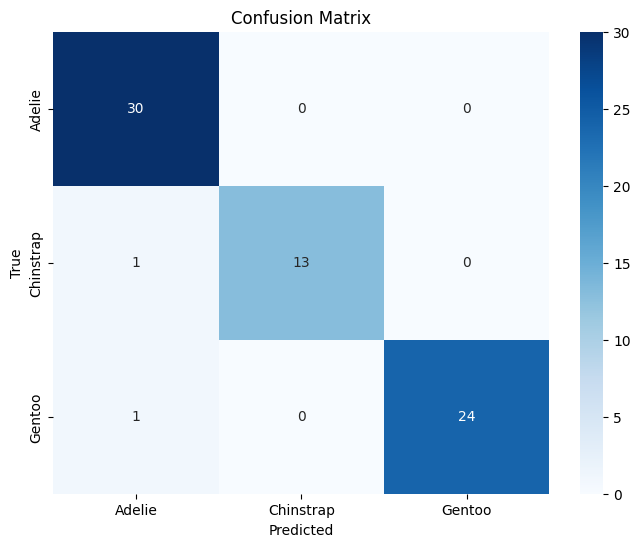

In [422]:
confusionMatrixReport(Y_test_80_20, Y_predict_80_20, clf_80_20, 80, 20)

## 4. 90/10 Data Split

### 4.1 Visualizing Decision Tree for 90/10 Data Split

Decision tree with dataset 90/10


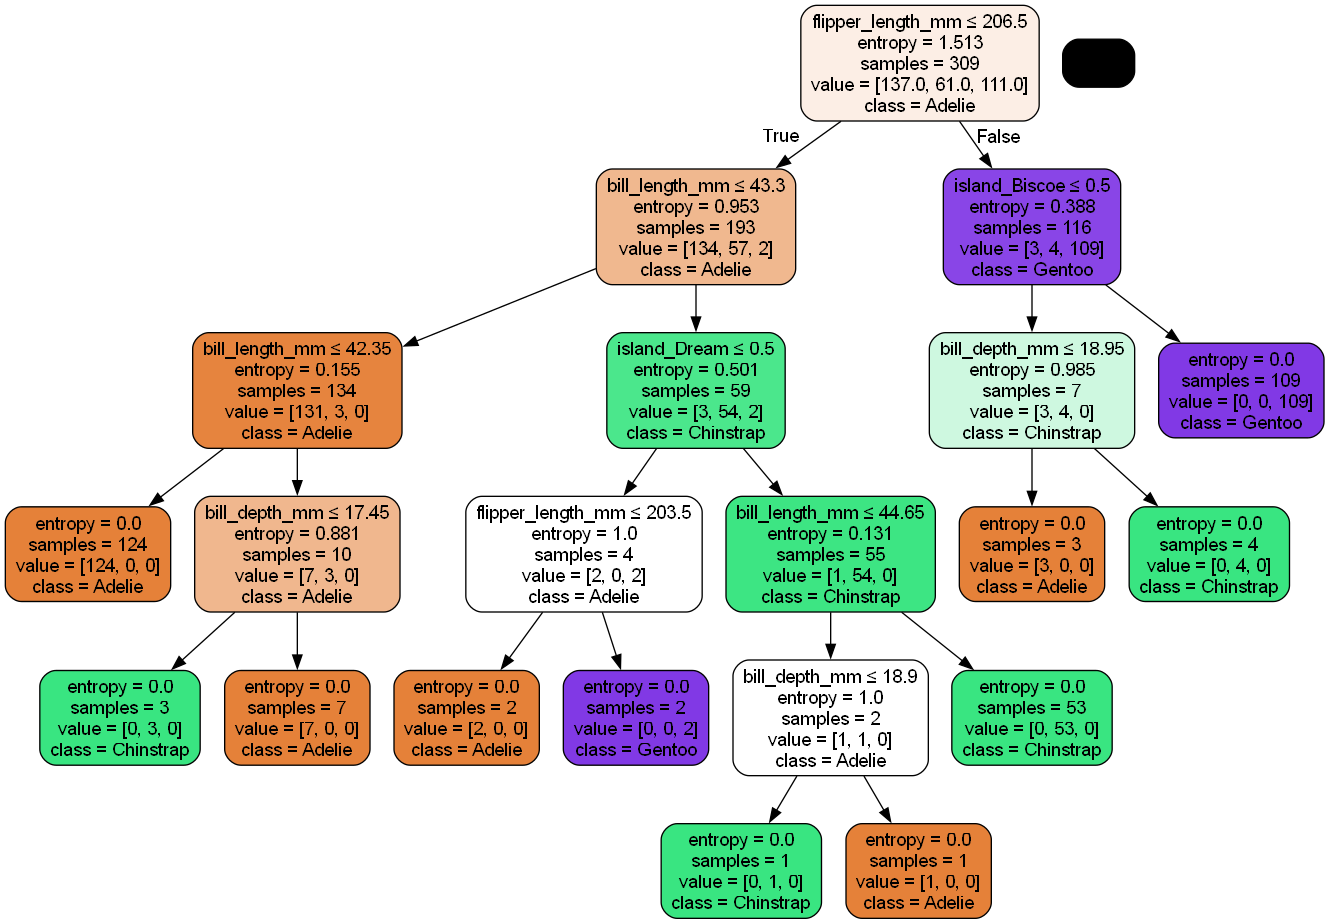

In [423]:
#Decision tree 90/10
dot_data = buildTree(clf_90_10, X_train_90_10, class_names)
drawTree(dot_data, 90, 10)

### 4.2 Classification Report for 90/10 Data Split

In [424]:
classificationReport(Y_test_90_10, Y_predict_90_10, 90, 10)

Classification Report (90/10):

              precision    recall  f1-score   support

      Adelie       0.88      1.00      0.94        15
   Chinstrap       1.00      0.86      0.92         7
      Gentoo       1.00      0.92      0.96        13

    accuracy                           0.94        35
   macro avg       0.96      0.93      0.94        35
weighted avg       0.95      0.94      0.94        35



### 4.3 Confusion Matrix for 90/10 Data Split

Confusion Matrix (Depth=5, 90/10 split):



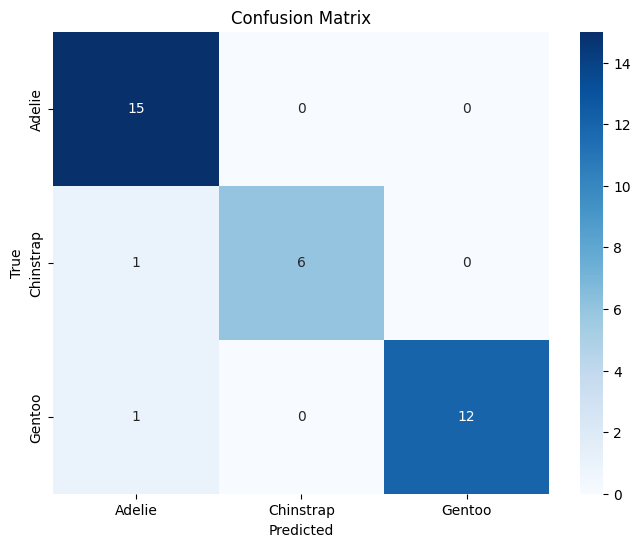

In [425]:
confusionMatrixReport(Y_test_90_10, Y_predict_90_10, clf_90_10, 90, 10)

# IV. The depth and accuracy of a decision tree

## 1. Prepare dataset 80/20 for each depth

In [426]:
#Prepare dataset 80/20 for each depth
max_depth = [None, 2, 3, 4, 5, 6, 7]
accuracies = []
trees = {}

for depth in max_depth:
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=depth)
    clf.fit(X_train_80_20, Y_train_80_20)
    Y_predict = clf.predict(X_test_80_20)
    accuracies.append(metrics.accuracy_score(Y_test_80_20, Y_predict))
    trees[depth] = clf

## 2. Visualizing Max Depth with 80/20 Data Split in Decision Tree

Decision Tree (max_depth=None)


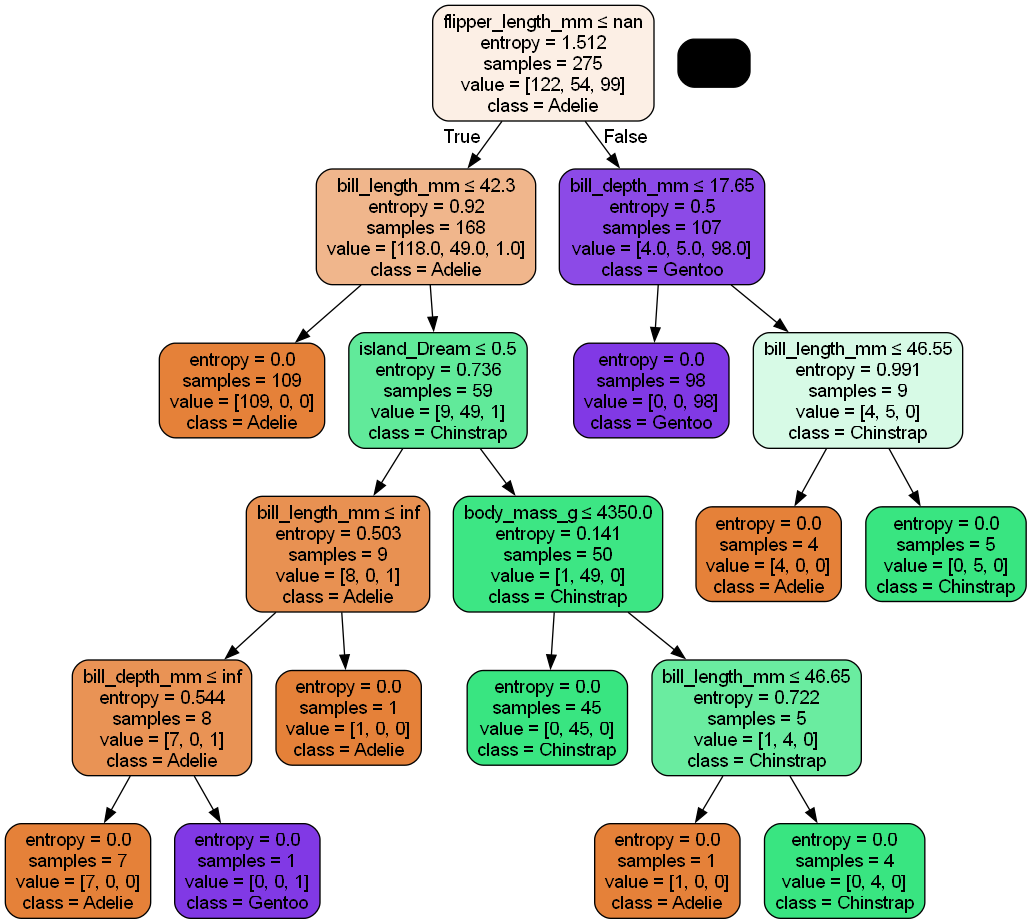

Decision Tree (max_depth=2)


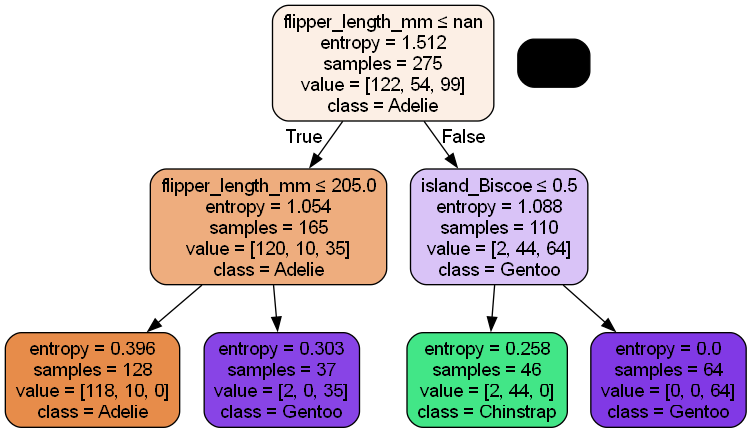

Decision Tree (max_depth=3)


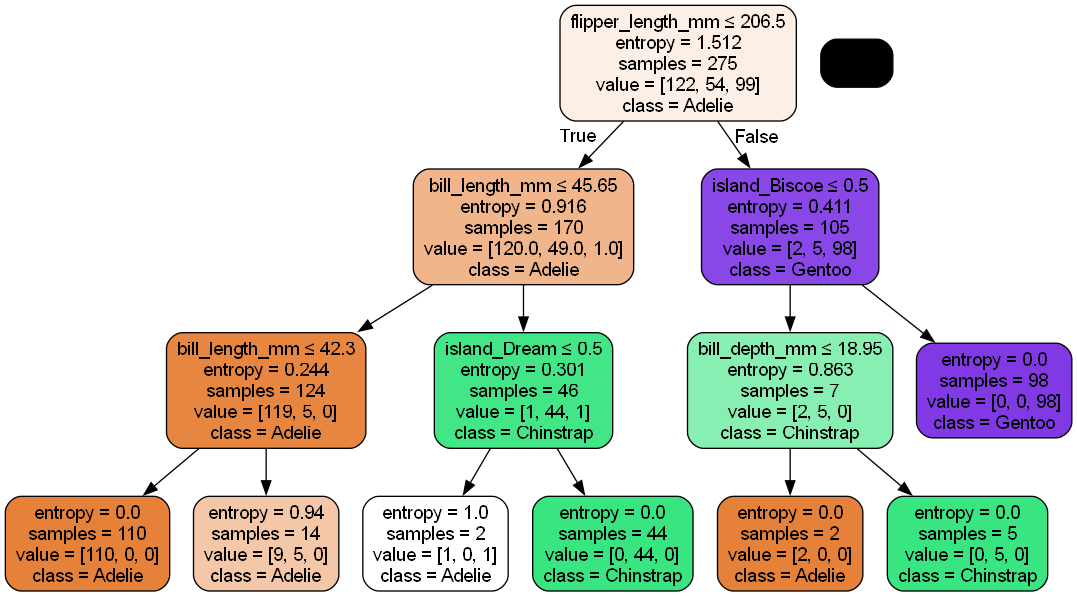

Decision Tree (max_depth=4)


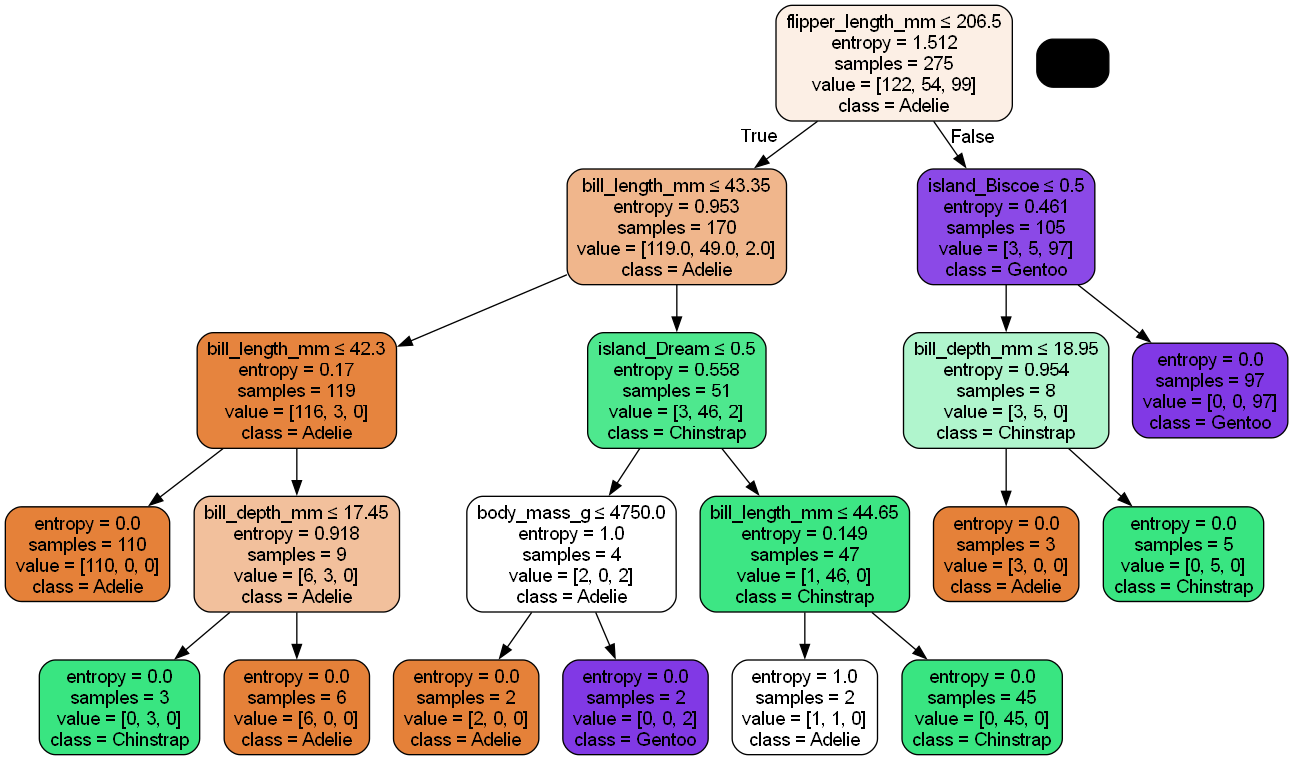

Decision Tree (max_depth=5)


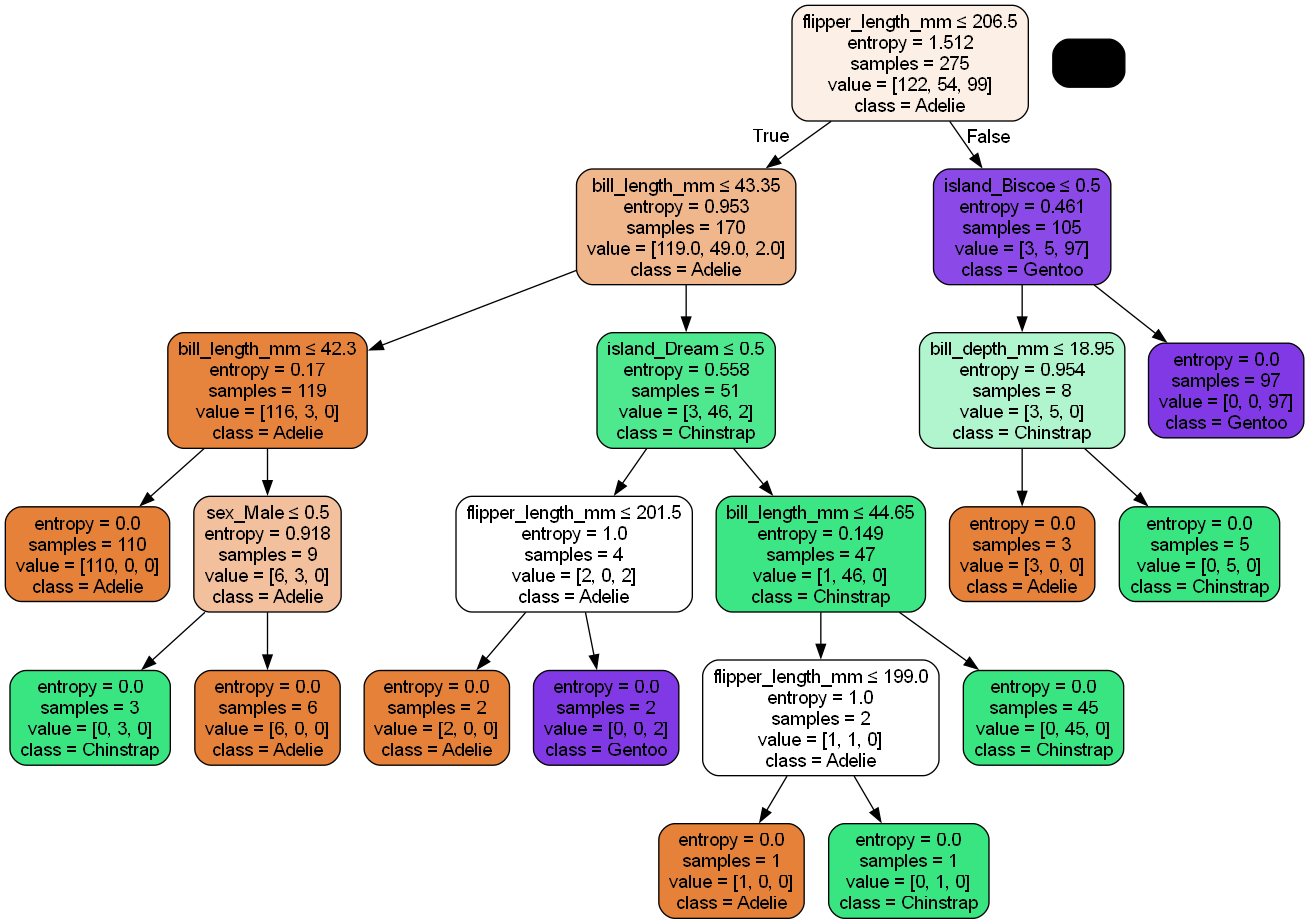

Decision Tree (max_depth=6)


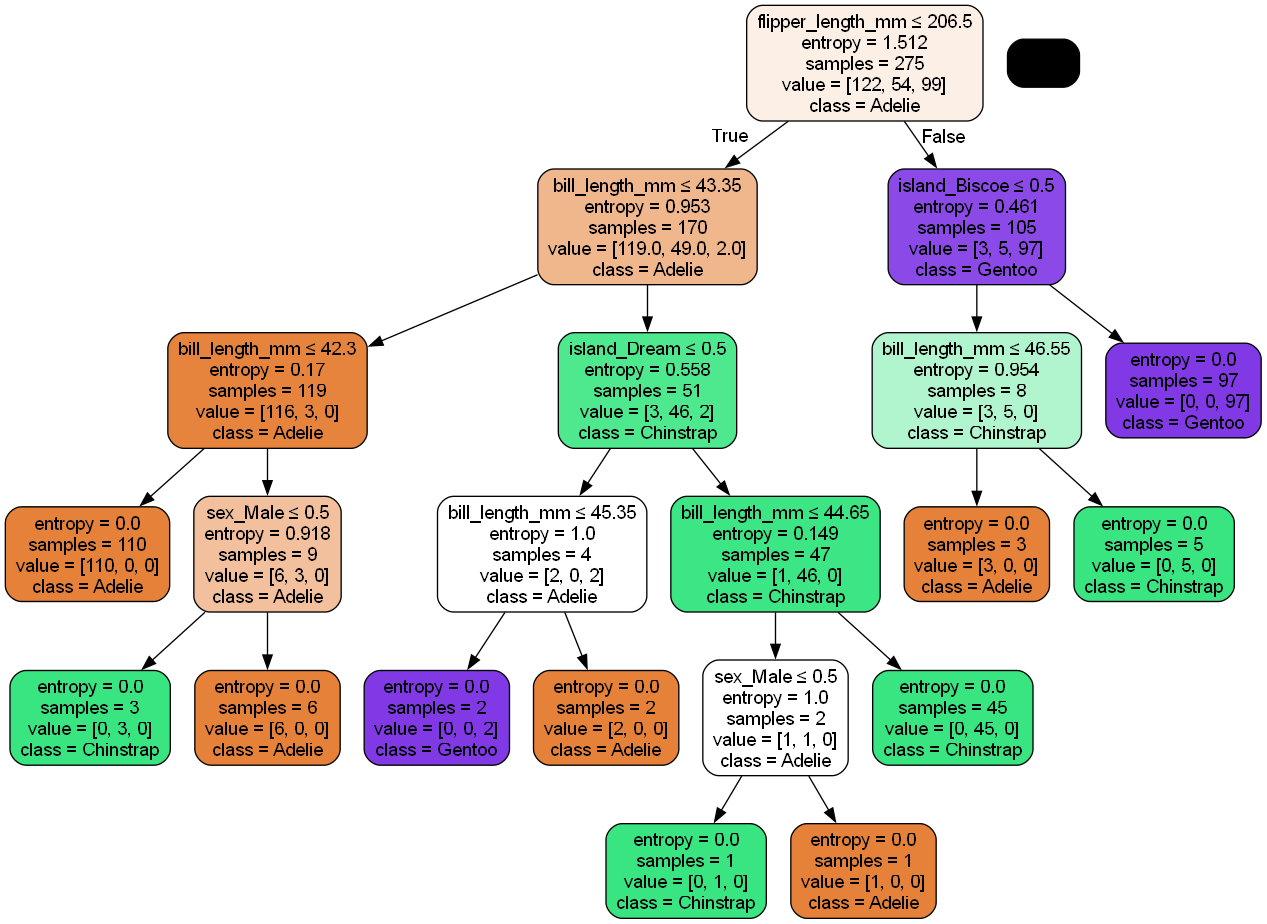

Decision Tree (max_depth=7)


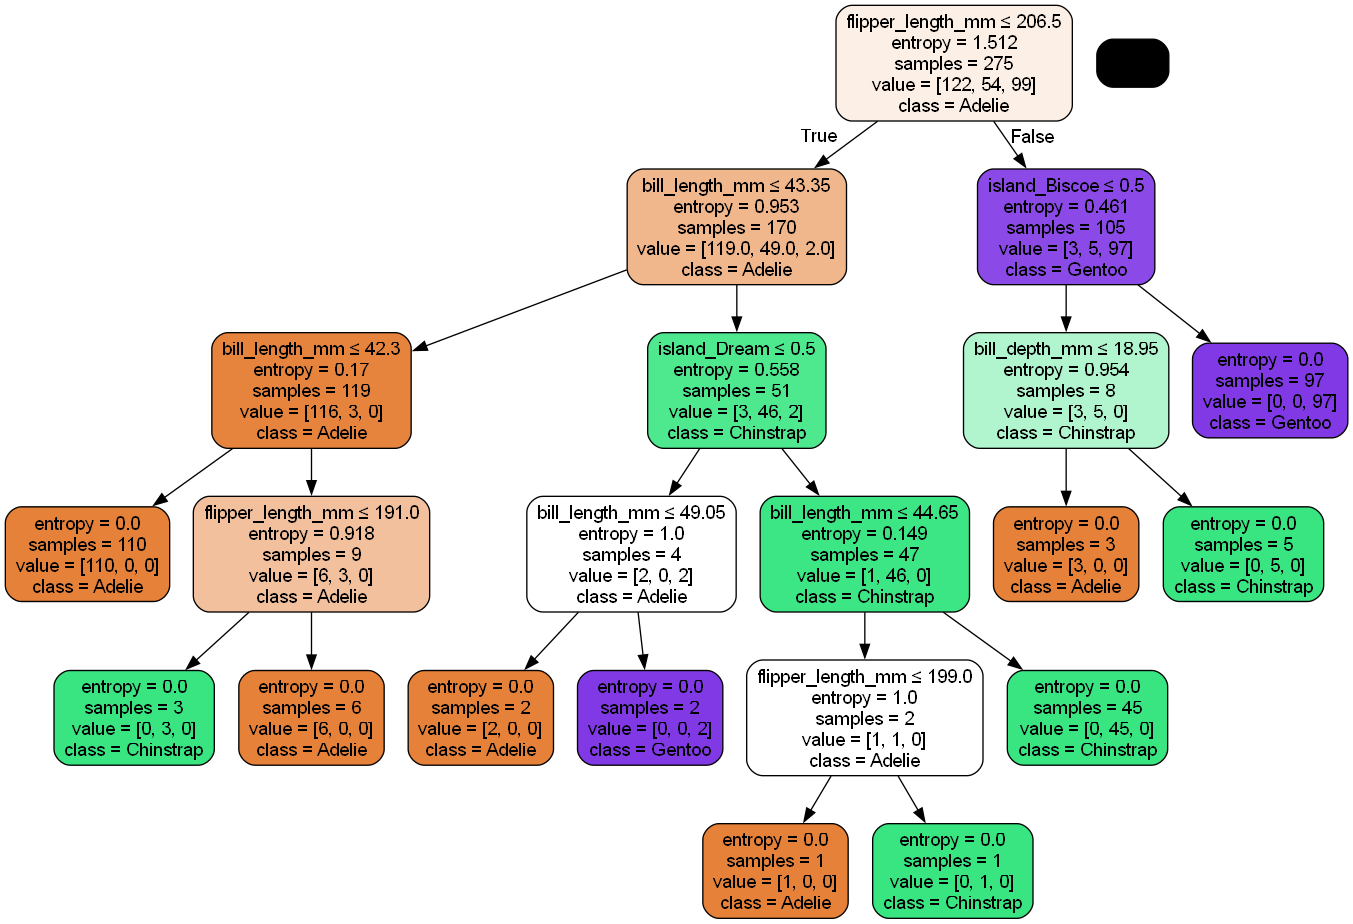

In [427]:
#Decision tree 80/20
for depth in max_depth:
    dot_data = buildTree(trees[depth], X_train_80_20, class_names)
    drawTreeWithDepth(dot_data, depth)


## 3. Accuracy Table for Varying Max Depths

In [428]:
accuraciesReport(accuracies, max_depth)

max_depth      None         2         3         4         5         6         7
Accuracy   0.753623  0.565217  0.898551  0.971014  0.985507  0.971014  0.971014


## 4. Accuracy Chart for Varying Max Depths

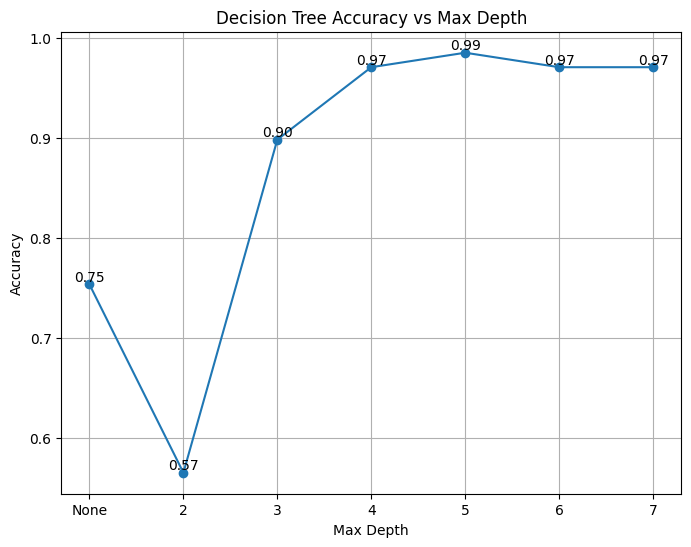

In [429]:
chartReport(accuracies)